In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob

In [2]:
#list of all disorders from the ldsc analysis
disorders = ['ADHD','ANOREXIA', 'ANXIETY','ASD','AUD','BIL. CHIR','BIP','CUD','EPILEPSY','FATIGUE','GOUT','HOARDING','IBS','LUPUS','MDD','MIGRAINE','MS','MYASTHENIA','OCD','OD','PANIC','PARKINSONS','PTSD','RH. ARTHRITIS','SJOGRENS','SZC','THYROID DIS.','TOURETTES']

In [3]:
#make list of files to read in
ex_table_files = glob.glob('*_extracted_table.txt')
# Sort the list of files based on the numeric part in the filenames
ex_table_files = sorted(ex_table_files, key=lambda x: int(x.split('_')[0]), reverse=True)

In [4]:

df_list = []

#read in files to dataframes 
for file in ex_table_files:
    df = pd.read_csv(file, delim_whitespace=True
                     , skiprows=1) 
    #select relevant columns
    df = df[['p1','p2','rg','se','z','p']]
    #remove last two rows
    df = df.iloc[:-2]
    df_list.append(df)

In [5]:
#function to fill a dataframe with values from the ldsc analysis

def make_correlation_matrix(column, df_list):
    array = np.zeros((len(disorders), len(disorders)))

    for i, df in enumerate(df_list):
        val = df[column].values

        if len(val) > 0:  # Check if 'rg' column is not empty
            for j in range(i + 1, len(val) + 1 + i):  # exclude the diagonal
                array[j, i] = val[j - i - 1]
                

    # Fill the diagonal 
    if column == 'rg':            
        np.fill_diagonal(array, 1)
    else: np.fill_diagonal(array,0.00005)

    # Convert the filled cells to numeric
    array = array.astype(float)

    # Create a DataFrame with disorders as column and index names
    return pd.DataFrame(array, index=disorders, columns=disorders), array

In [6]:
corr_pval_df = make_correlation_matrix('p', df_list)
gen_corr_df, corr_matrix = make_correlation_matrix('rg', df_list)

In [7]:
full_matrix = np.tril(corr_matrix) + np.tril(corr_matrix, -1).T
full_df = pd.DataFrame(full_matrix, index=disorders, columns=disorders)

In [8]:
full_df.to_csv('genetic_correlation.csv', header=True, index=True)
gen_corr_df.to_csv('genetic_correlation_all.csv', header= True, index=True)

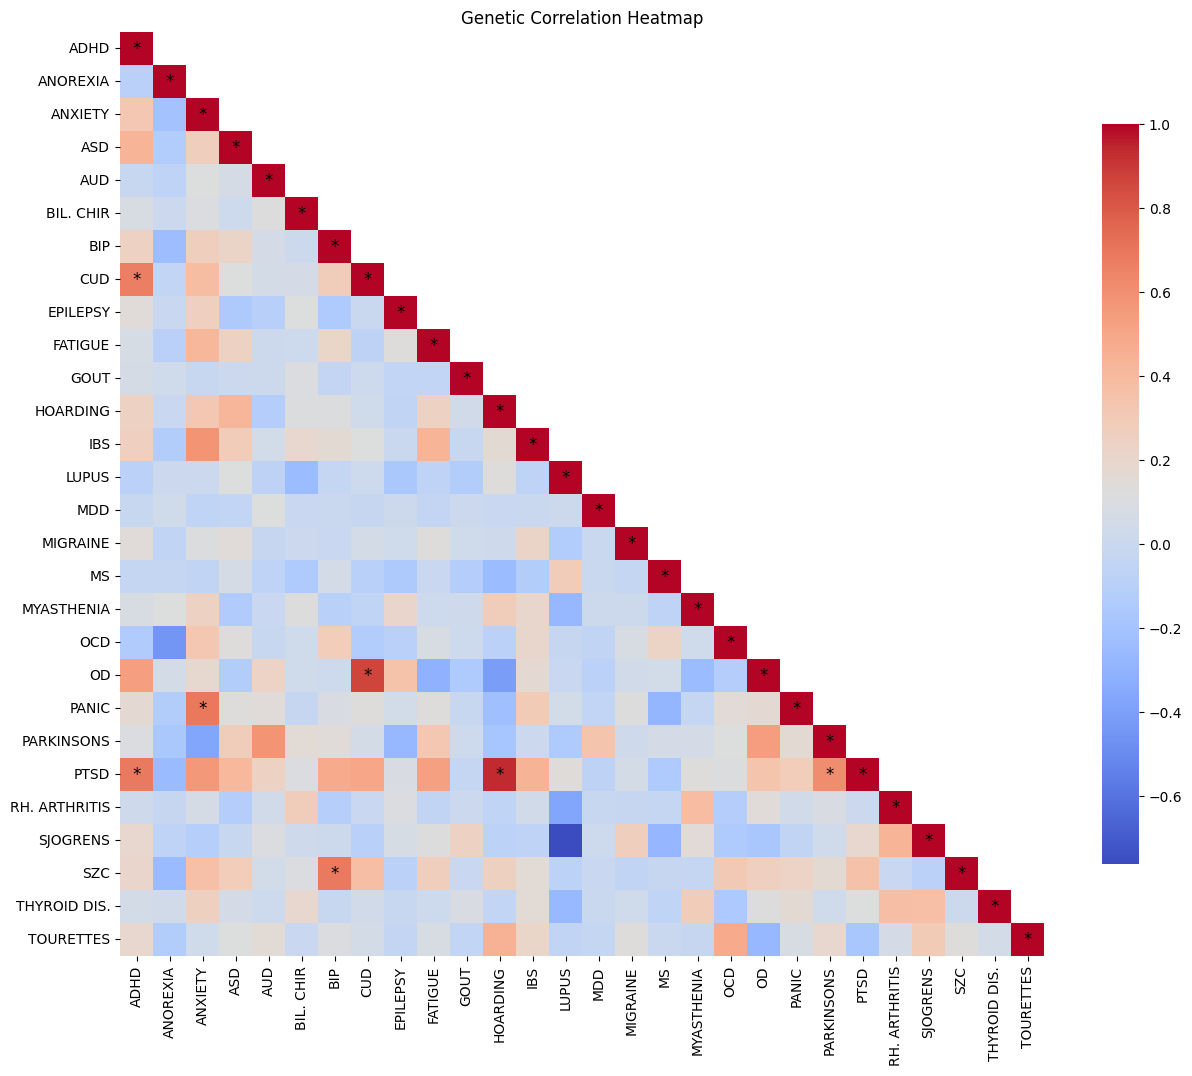

In [12]:
#define threshold
threshold = 0.6

# Create a mask for the upper triangular part over the diagonal
mask = np.triu(np.ones_like(gen_corr_df), k=1)

# Plot the heatmap
plt.figure(figsize=(15,12))
heatmap= sns.heatmap(gen_corr_df, cmap='coolwarm',mask=mask, square=True, cbar_kws={"shrink": 0.8})

# Add labels for values above the threshold
for i in range(len(gen_corr_df)):
    for j in range(len(gen_corr_df)):
        if mask[i, j] == 0 and gen_corr_df.iloc[i, j] > threshold:
            heatmap.text(j + 0.5, i + 0.5, '*', ha='center', va='center', color='black', fontsize=12)
plt.title('Genetic Correlation Heatmap')
plt.show()

<Figure size 2000x1500 with 0 Axes>

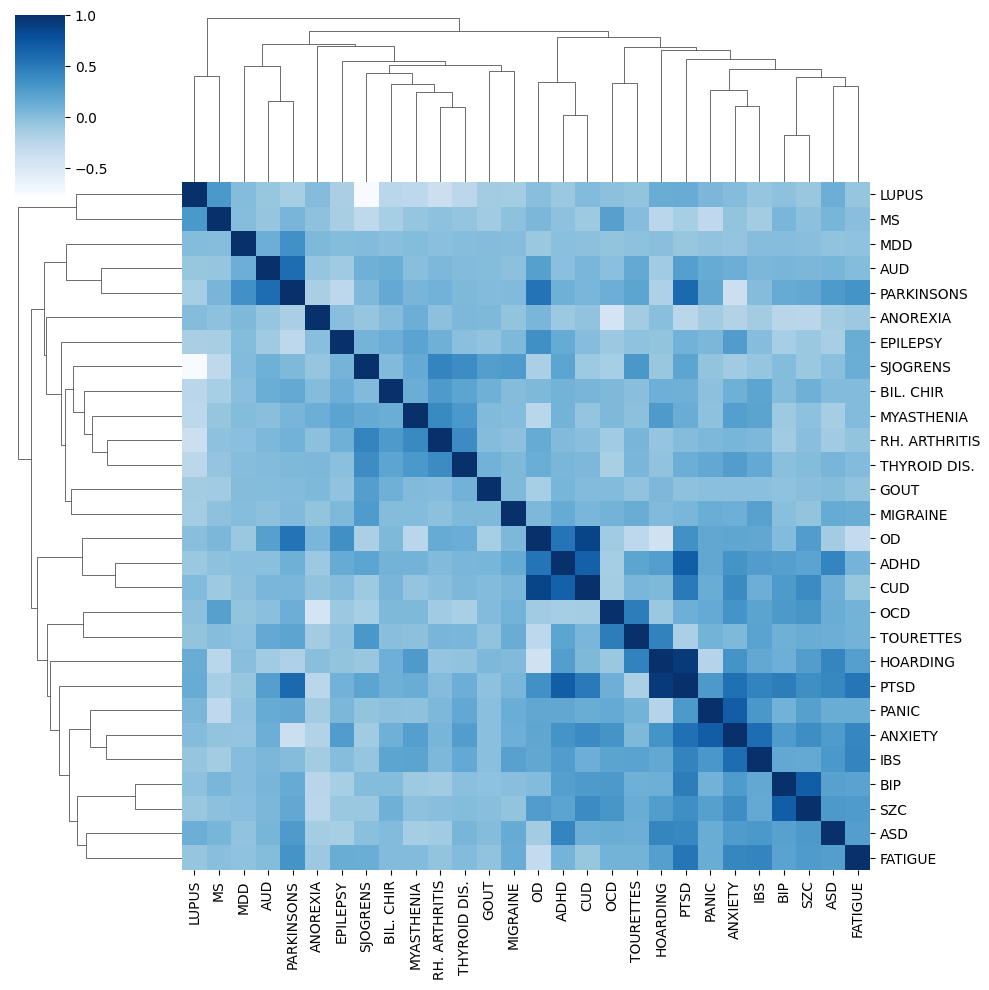

In [10]:
#plot clustermap
plt.figure(figsize=(20,15))
sns.clustermap(full_df,cmap='Blues')
plt.show()